# Synthetic control with scikit-learn models

In [1]:
import causalpy as cp

## Load data

In [2]:
df = cp.load_data("sc")
treatment_time = 70

### {term}`Donor pool selection`

Before fitting, it is good practice to inspect pairwise correlations among units in the pre-treatment period. Negatively correlated donors should be excluded to avoid interpolation bias {cite}`abadie2010synthetic,abadie2021using`.

[Text(0.5, 1.0, 'Pre-treatment correlations')]

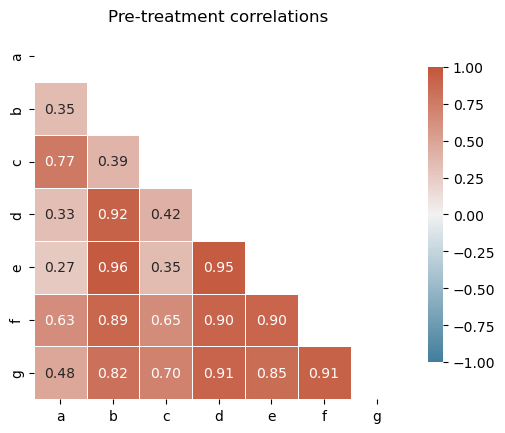

In [3]:
pre = df.loc[:treatment_time]
corr, ax = cp.plot_correlations(pre, columns=["a", "b", "c", "d", "e", "f", "g"])
ax.set(title="Pre-treatment correlations")

All control units are positively correlated with the treated unit (`actual`), so no {term}`donor pool` curation is needed for this dataset. In practice, you would exclude any controls with negative or near-zero correlations.

## Analyse with `WeightedProportion` model

In [4]:
result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=["a", "b", "c", "d", "e", "f", "g"],
    treated_units=["actual"],
    model=cp.skl_models.WeightedProportion(),
)

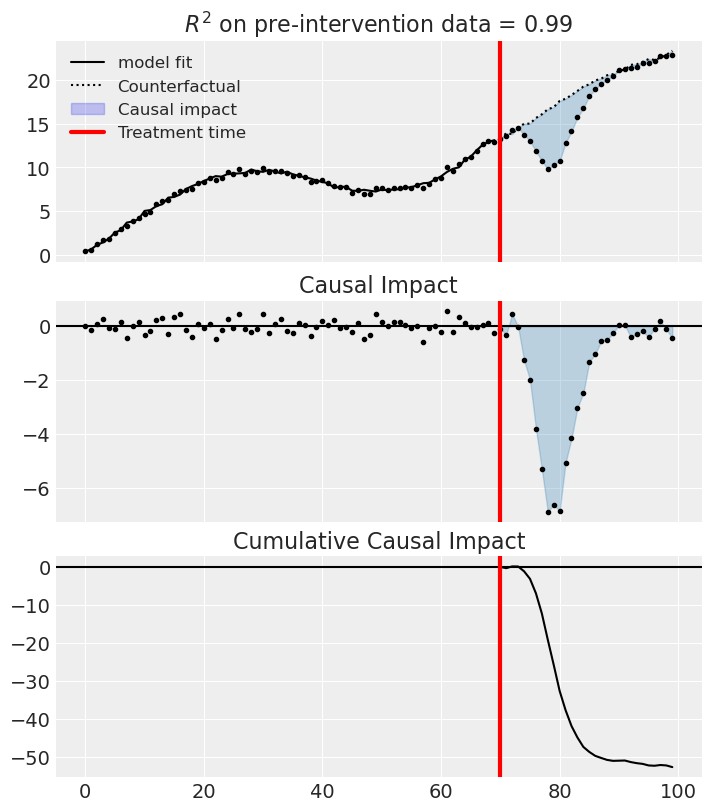

In [5]:
fig, ax = result.plot(plot_predictors=True)

In [6]:
result.summary(round_to=3)

================================SyntheticControl================================
Control units: ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Treated unit: actual
Model coefficients:
  a	     0.319
  b	    0.0597
  c	     0.294
  d	    0.0605
  e	  0.000762
  f	     0.234
  g	    0.0321
Pre-treatment correlation (actual): 0.9961


We can get nicely formatted tables from our integration with the [maketables](https://github.com/py-econometrics/maketables) package.

In [7]:
from maketables import ETable

ETable(result, coef_fmt="b:.3f")

<maketables.mtable.MTable.__repr__.<locals>.DualOutput at 0x11c8cdfd0>

## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics.

:::{note}
**OLS vs PyMC Models**: When using OLS models (scikit-learn), the `effect_summary()` provides **confidence intervals** and **p-values** (frequentist inference), rather than the posterior distributions, HDI intervals, and tail probabilities provided by PyMC models (Bayesian inference). OLS tables include: mean, CI_lower, CI_upper, and p_value, but do not include median, tail probabilities (P(effect>0)), or ROPE probabilities.
:::


In [8]:
# Generate effect summary for the full post-period
stats = result.effect_summary()
stats.table

,mean,ci_lower,ci_upper,p_value,relative_mean,relative_ci_lower,relative_ci_upper
average,-1.757497,-2.625051,-0.889943,0.000271,-10.132258,-15.262594,-5.001922
cumulative,-52.724906,-78.751527,-26.698285,0.000271,-303.967742,-457.877825,-150.057659


In [9]:
# View the prose summary
print(stats.text)

During the Post-period (70 to 99), the response variable had an average value of approx. 17.07. By contrast, in the absence of an intervention, we would have expected an average response of 18.83. The 95% confidence interval of this counterfactual prediction is [17.96, 19.70]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -1.76 with a 95% confidence interval of [-2.63, -0.89].

Summing up the individual data points during the Post-period, the response variable had an overall value of 512.18. By contrast, had the intervention not taken place, we would have expected a sum of 564.91. The 95% confidence interval of this prediction is [538.88, 590.94].

The 95% confidence interval of the effect [-2.63, -0.89] does not include zero (p-value 0.000). Relative to the counterfactual, the effect represents a -10.13% change (95% CI [-15.26%, -5.00%]).

This analysis assumes that the contr

But we can see that (for this dataset) these estimates are quite bad. So we can lift the "sum to 1" assumption and instead use the `LinearRegression` model, but still constrain weights to be positive. Equally, you could experiment with the `Ridge` model (e.g. `Ridge(positive=True, alpha=100)`).

## References

:::{bibliography}
:filter: docname in docnames
:::